In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import glob

import tensorflow as tf
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
from agnfinder.prospector import load_photometry
from agnfinder.tf_sampling import deep_emulator

In [65]:
os.chdir('/home/mike/repos/agnfinder')

### Convert everything to parquet

In [4]:
data_dir = '/media/mike/beta/agnfinder/uK_IR/selected'
assert os.path.isdir(data_dir)
fits_locs = glob.glob(data_dir + '/*.fits')
assert fits_locs

In [5]:
for fits_loc in fits_locs:
    fits = Table.read(fits_loc)
    df = fits.to_pandas()
    parquet_loc = fits_loc.rstrip('fits') + 'parquet'
    df.to_parquet(parquet_loc)

### Check they load and normalise/denormalise correctly

In [6]:
parquet_locs = glob.glob(data_dir + '/*.parquet')
assert parquet_locs

In [7]:
def load_real_galaxy(parquet_loc):
    # not designed to scale easily, loads df every time. Can change to hdf5 later
    df = pd.read_parquet(parquet_loc)
    galaxy = df.iloc[0]
    _, maggies, maggies_unc = load_photometry.load_maggies_from_galaxy(galaxy, reliable=True)
    return maggies, maggies_unc

In [8]:
maggies, maggies_unc = load_real_galaxy(parquet_locs[0])

In [9]:
maggies

array([8.97925081e-09, 5.50088098e-08, 1.36326123e-07, 2.03466345e-07,
       2.86353580e-07, 4.03908316e-07, 3.27287289e-07, 3.92900064e-07,
       2.73501478e-07, 2.32374996e-07, 1.96871625e-07, 1.25575484e-07])

In [10]:
deep_emulator.denormalise_photometry(deep_emulator.normalise_photometry(maggies))

array([8.97925081e-09, 5.50088098e-08, 1.36326123e-07, 2.03466345e-07,
       2.86353580e-07, 4.03908316e-07, 3.27287289e-07, 3.92900064e-07,
       2.73501478e-07, 2.32374996e-07, 1.96871625e-07, 1.25575484e-07])

### Save as one parquet with a feature column indicating galaxy type

In [14]:
dfs = []
for loc in parquet_locs:
    dfs.append(pd.read_parquet(loc))
len(dfs)

5

In [29]:
df = pd.concat(dfs, axis=0).reset_index(drop=True)
len(df)

35

In [30]:
df.sample(5)

,id,alpha,delta,redshift,hclass,hquality,survey_quality,survey_comment,sp_survey,id_sdss_u_dr12,...,zopt_b_2_case_III,zopt_b_3_case_III,class_opt_a_0_case_III,class_opt_a_1_case_III,class_opt_a_2_case_III,class_opt_a_3_case_III,class_opt_b_0_case_III,class_opt_b_1_case_III,class_opt_b_2_case_III,class_opt_b_3_case_III
30,b'337884624090851328 ',207.06202,1.049917,0.471133,3,1,b'0 ',b'QSO_BROADLINE ',b'sdss_dr12 ',1237648705661173944,...,0.4545,0.4545,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
32,b'151657002131521536 ',223.23181,1.972190,0.097560,-1,1,b'4 ',b'0.912 ',b'gama_dr2 ',1237651754029220008,...,0.0921,0.0921,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
31,b'368179478507055104 ',174.67725,-2.554872,0.105049,1,1,b'0 ',b'GALAXY_STARFORMING ',b'sdss_dr12 ',1237671141479678223,...,0.1394,0.1394,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
7,b'336783463279519744 ',205.78589,0.417359,0.104608,1,1,b'0 ',b'GALAXY_STARBURST ',b'sdss_dr12 ',1237671991341940979,...,0.1618,0.1618,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
18,b'4251528427758874624 ',178.47312,-2.245790,2.266393,3,1,b'0 ',b'QSO_BROADLINE ',b'sdss_dr12 ',1237650371018162282,...,2.0451,2.0451,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [32]:
df.columns.values

array(['id', 'alpha', 'delta', 'redshift', 'hclass', 'hquality',
       'survey_quality', 'survey_comment', 'sp_survey', 'id_sdss_u_dr12',
       'tile_name_sdss_u_dr12', 'alpha_sdss_u_dr12', 'delta_sdss_u_dr12',
       'flags_sdss_u_dr12', 'flux_radius_sdss_u_dr12', 'fwhm_sdss_u_dr12',
       'mag_auto_sdss_u_dr12', 'magerr_auto_sdss_u_dr12',
       'mag_aper2_sdss_u_dr12', 'magerr_aper2_sdss_u_dr12',
       'mag_aper3_sdss_u_dr12', 'magerr_aper3_sdss_u_dr12',
       'id_sdss_g_dr12', 'tile_name_sdss_g_dr12', 'alpha_sdss_g_dr12',
       'delta_sdss_g_dr12', 'flags_sdss_g_dr12',
       'flux_radius_sdss_g_dr12', 'fwhm_sdss_g_dr12',
       'mag_auto_sdss_g_dr12', 'magerr_auto_sdss_g_dr12',
       'mag_aper2_sdss_g_dr12', 'magerr_aper2_sdss_g_dr12',
       'mag_aper3_sdss_g_dr12', 'magerr_aper3_sdss_g_dr12',
       'id_sdss_r_dr12', 'tile_name_sdss_r_dr12', 'alpha_sdss_r_dr12',
       'delta_sdss_r_dr12', 'flags_sdss_r_dr12',
       'flux_radius_sdss_r_dr12', 'fwhm_sdss_r_dr12',
       '

In [40]:
hclass_schema = {
    1: 'galaxy',
    2: 'agn',
    3: 'qso',
    -1: 'unknown'
}
df['hclass_name'] = df['hclass'].apply(lambda x: hclass_schema[x])
df['hclass_name'].value_counts()

unknown    16
galaxy      9
qso         8
agn         2
Name: hclass_name, dtype: int64

In [48]:
rf_classes = ['passive', 'starforming', 'starburst', 'agn', 'qso', 'outlier']


In [49]:
for c in rf_classes:
    print('{}: {:.2f}'.format(c, df[f'Pr[{c}]_case_III'].sum()))

passive: 9.75
starforming: 6.82
starburst: 6.83
agn: 4.55
qso: 7.05
outlier: 0.34


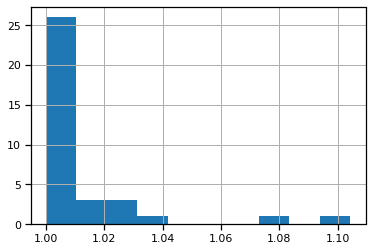

In [51]:
# check p's sum to 1
rf_cols = [f'Pr[{c}]_case_III' for c in rf_classes]
df[rf_cols].sum(axis=1).hist()
# close enough!

In [59]:
def does_galaxy_load(galaxy):
    try:
        _ = load_photometry.load_maggies_from_galaxy(galaxy, reliable=True)
        return True
    except ValueError:
        return False

In [60]:
df['has_valid_filters'] = df.apply(does_galaxy_load, axis=1)
df['has_valid_filters'].value_counts()

True     34
False     1
Name: has_valid_filters, dtype: int64

In [66]:
df = df.query('has_valid_filters==True')
df.to_parquet(os.path.join(data_dir, 'uk_ir_selection.parquet'))
df.to_parquet('data/uk_ir_selection.parquet')

In [11]:
# deep_emulator.normalise_photometry(maggies_unc)

In [12]:
# parquet_loc = fits_loc.rstrip('.fits') + '.parquet'
# parquet_loc
# if not os.path.exists(parquet_loc):
#     df.to_parquet(parquet_loc)